# Определение стоимости автомобилей
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля.
## Цель исследования:
Нужно построить модель для определения стоимости.

**Заказчику важны:**
- качество предсказания;
- скорость предсказания;
- время обучения.

## Описание данных
**Признаки**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак**
- Price — цена (евро)

## Загрузка библиотек

In [67]:
! pip install -q phik

In [68]:
! pip install -q catboost

In [69]:
import pandas as pd
import numpy as np
from math import sqrt
import phik

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb
import xgboost as xgb

# Другое
pd.options.display.expand_frame_repr = False
import warnings
warnings.filterwarnings('ignore')
from time import time

# Загрузка файлов с диска
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Загрузка и изучение данных

In [70]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/datasets/8_autos.csv')
df.sample(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
321098,2016-03-17 11:06:23,3800,small,2005,manual,75,ibiza,125000,12,petrol,seat,no,2016-03-17 00:00:00,0,57537,2016-04-05 22:45:25
84058,2016-03-06 20:23:46,7500,sedan,2003,auto,184,x_reihe,150000,12,gasoline,bmw,no,2016-03-06 00:00:00,0,65428,2016-03-15 06:15:19
90674,2016-03-25 10:46:43,10450,wagon,2006,manual,231,3er,150000,4,gasoline,bmw,no,2016-03-25 00:00:00,0,44534,2016-04-06 10:16:25
353081,2016-03-26 07:02:44,9900,wagon,2006,auto,232,a4,150000,6,gasoline,audi,no,2016-03-26 00:00:00,0,89423,2016-04-05 19:47:04
319629,2016-03-29 22:45:38,3333,wagon,2003,manual,163,5er,150000,9,gasoline,bmw,no,2016-03-29 00:00:00,0,31134,2016-03-29 22:45:38
267666,2016-03-16 16:54:57,6490,small,2013,manual,68,c1,40000,1,petrol,citroen,no,2016-03-16 00:00:00,0,4249,2016-04-06 21:47:01
271084,2016-03-21 23:49:41,150,other,1999,manual,90,megane,150000,1,petrol,renault,NaN,2016-03-21 00:00:00,0,59427,2016-03-23 13:18:37
271490,2016-03-20 18:16:10,798,small,1997,manual,45,corsa,90000,2,petrol,opel,yes,2016-03-19 00:00:00,0,35440,2016-03-23 21:48:04
217894,2016-03-12 17:47:41,1500,wagon,1999,manual,125,a4,150000,8,petrol,audi,no,2016-03-12 00:00:00,0,45478,2016-03-24 17:16:05
86700,2016-03-20 11:53:02,3000,small,2004,NaN,0,a4,150000,0,gasoline,audi,NaN,2016-03-20 00:00:00,0,51065,2016-03-20 11:53:02


In [71]:
df.tail()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [73]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [74]:
# Посмотрим, за какой период доступны данные
print('Данные доступны за период от', pd.to_datetime(df['DateCrawled'].min()), 'до', pd.to_datetime(df['DateCrawled'].max()))

Данные доступны за период от 2016-03-05 14:06:22 до 2016-04-07 14:36:58


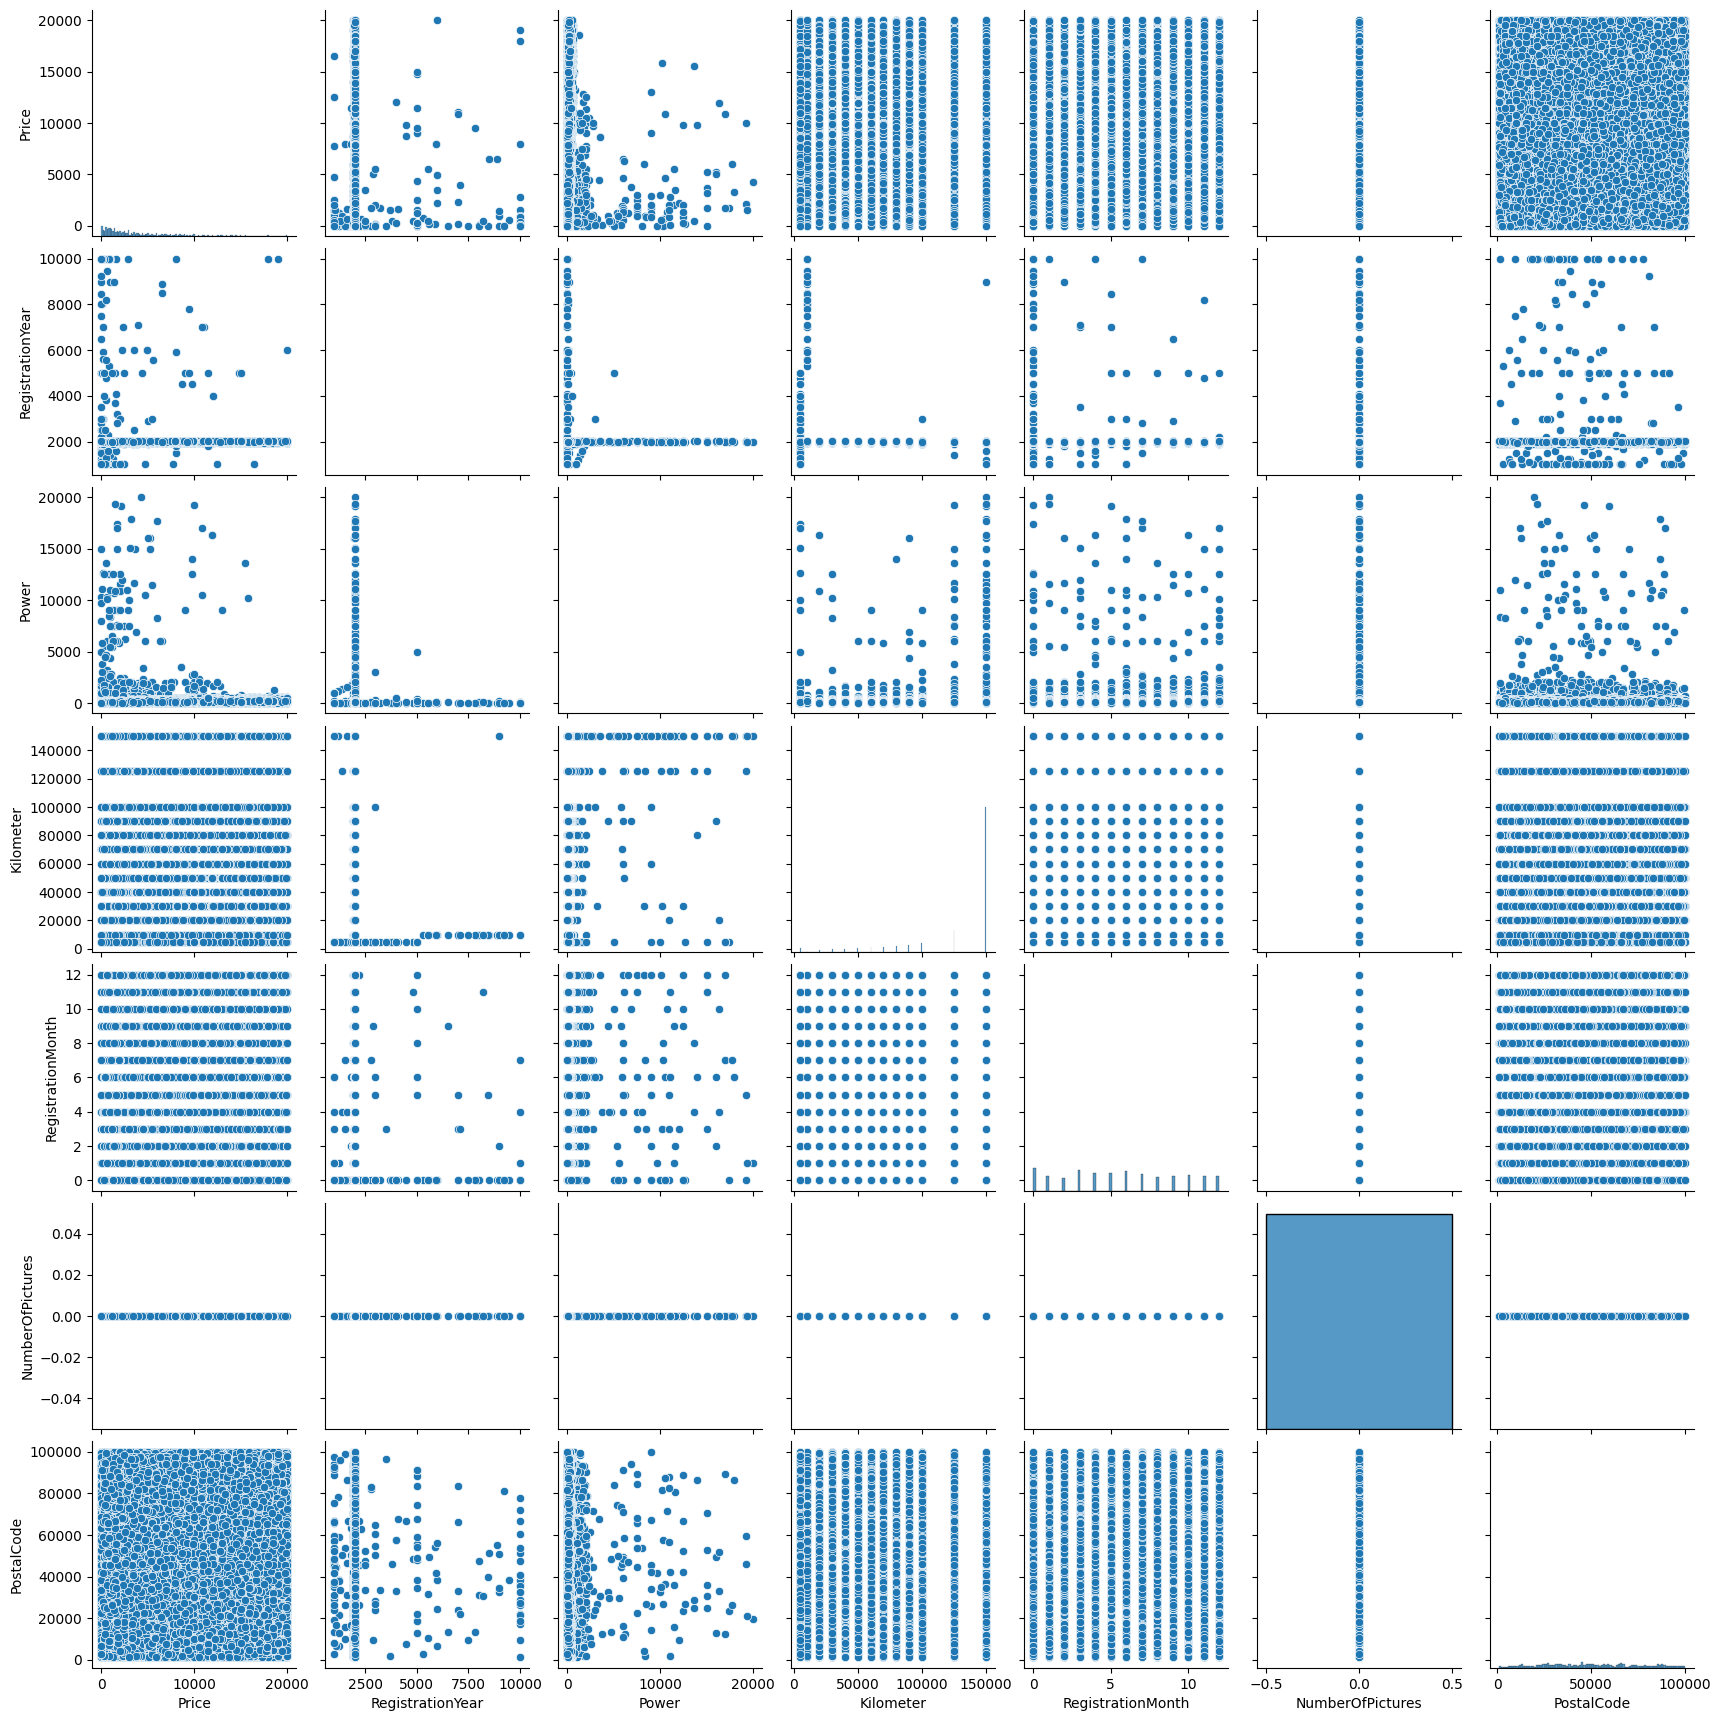

In [75]:
# Построим распределения данных в числовых признаках
# и на их зависимости от целевого признака Price
sns.pairplot(df)

> **К значимым признакам отнесем следующие столбцы:**
>
>- **VehicleType:** Тип машины определяет ее функционал. Чем больше возможносей у машины, тем выше цена.
>- **Gearbox:** Наличие автоматической коробки передач повышает стоимость машины из-за сложности конструкции.
>- **Power:** Мощность в лоашдиных силах (далее л.с.) напрямую влияют на цену.
- **Kilometer:** Имеет обратно пропорциональную зависиммость от цены. Чем больше километров проехала машина, тем меньше ее надежность и соответсвенно цена.
>- **FuelType:** Тип топлива определяет конструкцию двигателя внутреннего сгорания.
>- **Brand:** Концерн/компания, которая создала автомобиль показывает качество и надежность автомобиля.
>- **Repaired:** Машины, которые побывали в дорожно-транспортных проишествиях означает, что машина подвергалась изменениям и ее надежность ниже.
>- **RegistrationYear:** Год регистрации определяет сколько уже лет машина на ходу. соответвенно, чем больше возраст, тем меньше цена.
>- **Model** В купе с типом машины и брендом може влиять на популярность у покупателей.
>
>Остальные столбцы для модели не требуются, так как не влияют на стоимость.

## Предобработка данных

In [76]:
# в названиях столбцов: отделим слова нижним подчёркиванием
# регистр текста заменим на нижний
df.columns = df.columns.str.replace(r"([A-Z])", r" \1", regex=True).str.lower().str.replace(' ', '_').str[1:]
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Обработка дубликатов

In [77]:
# проверим данные на дубликаты
print('Количество дубликатов:', df.duplicated().sum())

Количество дубликатов: 4


In [78]:
df[df.duplicated() == True]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


In [79]:
# удалим дубликаты
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

### Удаление признаков

In [80]:
# Сократим дата фрейм до нужных столбцов
df = df[['price',
         'vehicle_type',
         'registration_year',
         'gearbox',
         'power',
         'model',
         'kilometer',
         'fuel_type',
         'brand',
         'repaired']]

### Обработка пропусков

In [81]:
pd.DataFrame(round(df.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
price,0.000000
vehicle_type,11.000000
registration_year,0.000000
gearbox,6.000000
power,0.000000
model,6.000000
kilometer,0.000000
fuel_type,9.000000
brand,0.000000
repaired,20.000000


> Признак model является одним из основных для предсказания цены. Пропущено 5.6% данных в этом признаке. Нет возможности восстановить корректно эти данные, удалим пропуски.
>
> С заказчиком нужно обсудить, будет ли на сайте модель обязательна для заполнения. Если нет, то как будет прогнозироваться стоимость, нашей моделью или вне нее? Если модель должна будет работать с такими пропусками, а восстановить их нет возможности, то можно заполнить их "unknown"

In [82]:
df = df.loc[~df['model'].isna()]

> Признаки vehicle_type, gearbox, fuel_type c большой вероятностью одинаковы в одинаковых моделях автомобилей. Заполним пропуски в данных признаках наиболее частым значением той же модели.

In [83]:
df['vehicle_type'] = df['vehicle_type'].fillna(df
                                               .groupby('model')['vehicle_type']
                                               .transform(lambda x: x.value_counts().idxmax())
                                              )

In [84]:
df['gearbox'] = df['gearbox'].fillna(df
                                     .groupby('model')['gearbox']
                                     .transform(lambda x: x.value_counts().idxmax())
                                    )

In [85]:
df['fuel_type'] = df['fuel_type'].fillna(df
                                         .groupby('model')['fuel_type']
                                         .transform(lambda x: x.value_counts().idxmax())
                                        )

> Доля пропусков в признаке repaired составляет 20% - значительна, чтобы просто так удалить. Но и заполнить пропуски на основе имеющихся не получится, поэтому заполним пропуски значением 'unknown'.

In [86]:
df['repaired'] = df['repaired'].fillna('unknown')

In [87]:
null = {'К-во пропусков': df.isnull().sum(), 'Доля пропусков, %': df.isnull().sum() / len(df) * 100}
pd.DataFrame(null)

,К-во пропусков,"Доля пропусков, %"
price,0,0.0
vehicle_type,0,0.0
registration_year,0,0.0
gearbox,0,0.0
power,0,0.0
model,0,0.0
kilometer,0,0.0
fuel_type,0,0.0
brand,0,0.0
repaired,0,0.0


### Обработка аномальных значений

#### В столбце registration_year
Даты выгрузки объявлений все в 2016. Поэтому дата выпуска автомобиля не может быть больше 2016.

In [88]:
f"Количество объявлений с неправильным годом выпуска авто: {len(df.loc[(df['registration_year'] < 1908) | (df['registration_year'] > 2016)])}"

'Количество объявлений с неправильным годом выпуска авто: 12516'

In [89]:
display(df.query('registration_year < 1908 or registration_year > 2016').head(),
        df.query('registration_year < 1908 or registration_year > 2016').tail())

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
22,2900,bus,2018,manual,90,meriva,150000,petrol,opel,no
26,5555,sedan,2017,manual,125,c4,125000,gasoline,citroen,no
48,7750,sedan,2017,manual,80,golf,100000,petrol,volkswagen,unknown
51,2000,small,2017,manual,90,punto,150000,gasoline,fiat,yes
57,2399,sedan,2018,manual,64,other,125000,petrol,seat,no


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
354112,3600,bus,2017,manual,86,transit,150000,gasoline,ford,unknown
354140,1000,wagon,2017,manual,101,a4,150000,gasoline,audi,unknown
354203,2140,small,2018,manual,80,fiesta,150000,petrol,ford,no
354253,1250,small,2018,manual,0,corsa,150000,petrol,opel,unknown
354289,5000,sedan,2017,manual,120,other,150000,petrol,citroen,yes


> Цену с неправильным значением в столбце registration_year будет сложно предсказать, такие объявления могут внести ошибки в модель. Придётся удалить такие объекты.

In [90]:
print('Доля аномальных значений:', len(df.query('registration_year < 1908 or registration_year > 2016')) / len(df) *100)

Доля аномальных значений: 3.739915137751748


In [91]:
df = df.drop(df.query('registration_year < 1908 or registration_year > 2016').index).reset_index(drop=True)

#### В столбце price

In [92]:
# Проверим наполнение целевого признака price
df['price'].value_counts()

0        8020
500      5047
1500     4754
1200     4070
1000     4016
         ... 
3440        1
8889        1
859         1
18930       1
10985       1
Name: price, Length: 3639, dtype: int64

> Видно, что существует 8020 записи с ценой равной 0. Придётся такие записи удалить.

In [93]:
df = df.query('price > 0')

In [94]:
# # функция, получающая на вход признак и его название,
# и возвращающая графики информацию распределения признака
def viz_distribution(col, col_name):

    sns.displot(x = col, legend=True, kde=True, height=5.7, aspect=1.5, bins=100)
    plt.title('Распределение значений признака ' + str(col_name).title(), fontsize=16)

    plt.figure(figsize=(9.7, 6))
    sns.boxplot(y=col)

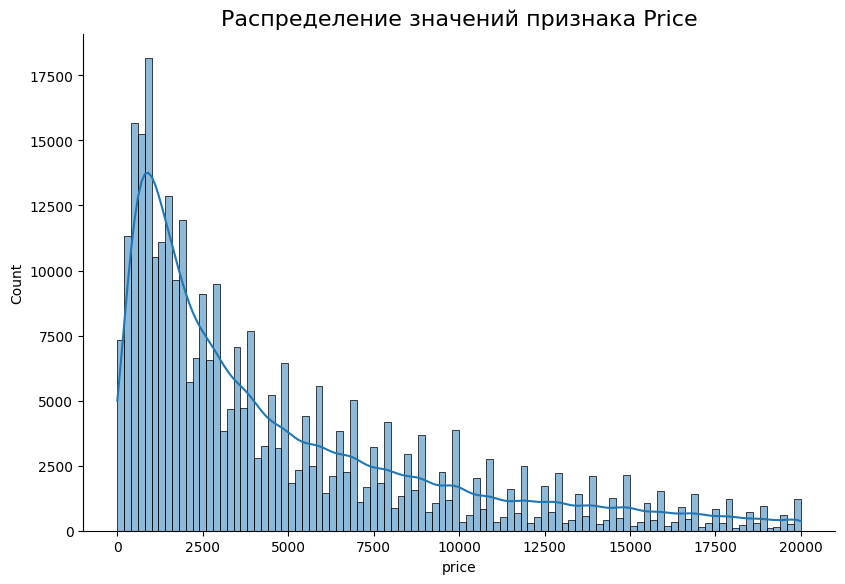

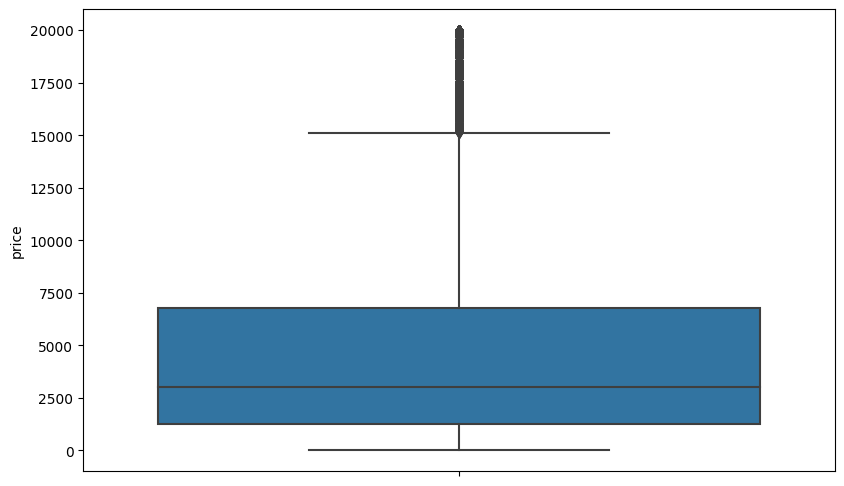

In [95]:
viz_distribution(df['price'], 'price')

> Ограничимся удалением только нулевой цены. Из распределения видно, что дорогие автомобили вполне вписываются в распределение.

#### В столбце power

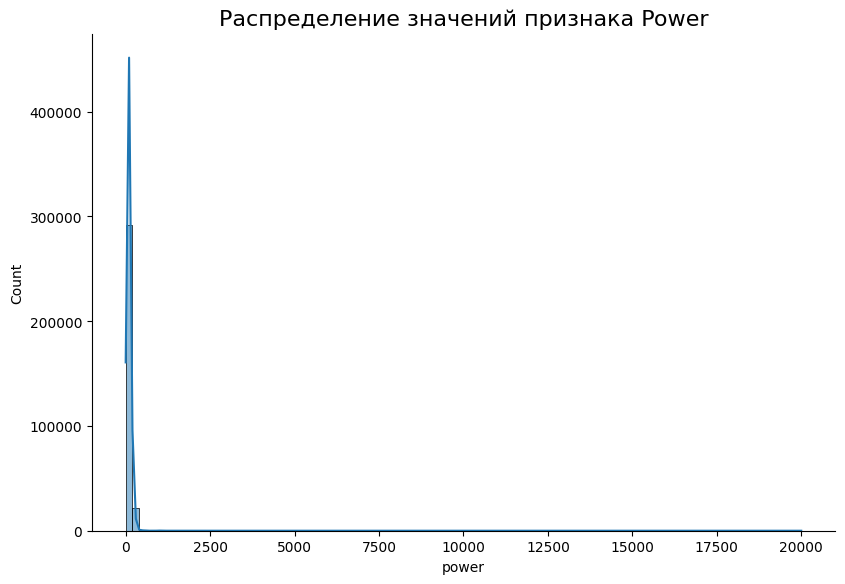

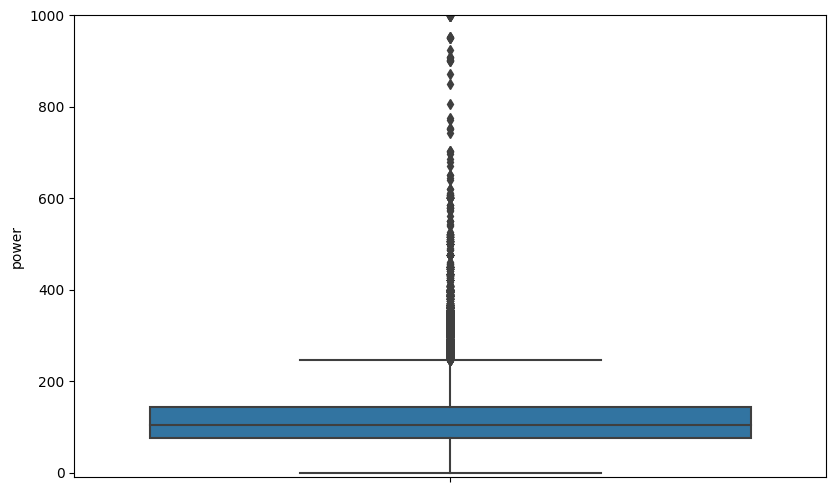

In [96]:
viz_distribution(df['power'], 'power')
plt.ylim(-10, 1000);

> Видим, что этот признак содержит большое количество объектов со значением 0. Скорее всего, владелец автомобиля, при заполнинии анкеты, посто не указал мощность своего автомобиля, поэтому эти 0 можно воспринимать как пропуски и заменить на медиану, в зависимости от такого признака как model.

In [97]:
df.loc[(df['power'] == 0), 'power'] = None
df['power'] = df['power'].fillna(df.groupby('model')['power'].transform('median'))
df = df.loc[~df['power'].isna()]

count    313481.000000
mean        119.092824
std          51.312855
min           1.000000
25%          75.000000
50%         110.000000
75%         145.000000
max         399.000000
Name: power, dtype: float64

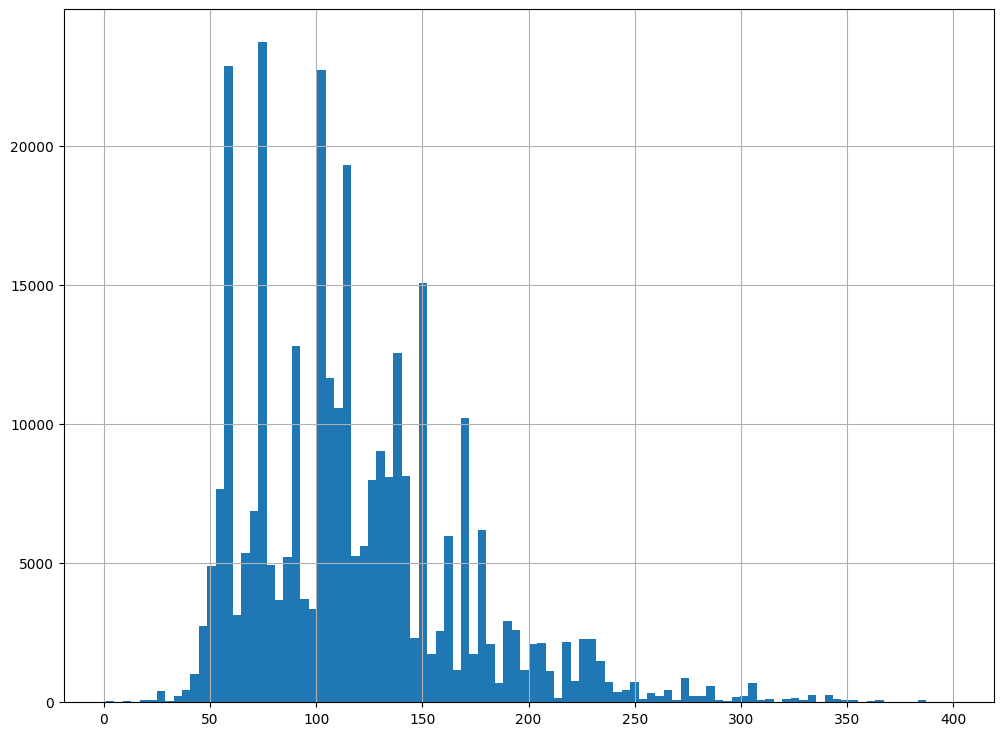

In [98]:
filtered_data = df.query('power < 400')
filtered_data['power'].hist(bins=100, figsize=(12,9))
filtered_data['power'].describe()

In [99]:
print('Доля аномальных значений:', len(df.query('power < 25 or power > 350')) / len(df) *100)

Доля аномальных значений: 0.4020717999000392


In [100]:
# удалим аномальные значения признака Power
df = df.drop(df.query('power < 25 or power > 350')
             .index).reset_index(drop=True)

#### В столбце kilometer

count    312860.000000
mean     128466.342773
std       36985.972354
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

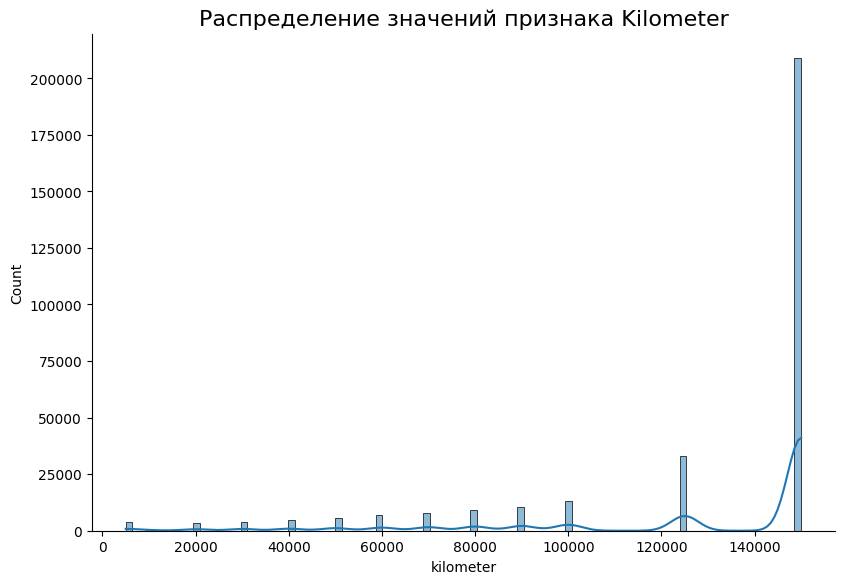

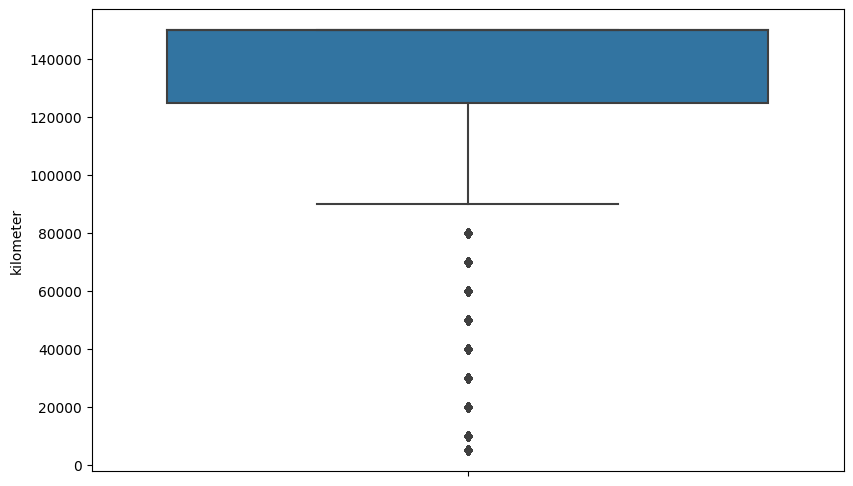

In [101]:
viz_distribution(df['kilometer'], 'kilometer')
df['kilometer'].describe()

> Здесь интересно отметить, что медиана признака Kilometer - это одновременно и максимальный зафиксированный пробег. Возможно это как-то связано с ограничением анкеты, например, в анкете нельзя ввести более высокий показатель.
>
> Еще стоит отметить, что данный признак распределен дискретно и, по сути, его можно отнести к категориальными признаками.
>
> Учитывая, что на продажу выставлены самые разные автомобили и пробег у них может быть абсолютно разным, этот признак трогать не будем.

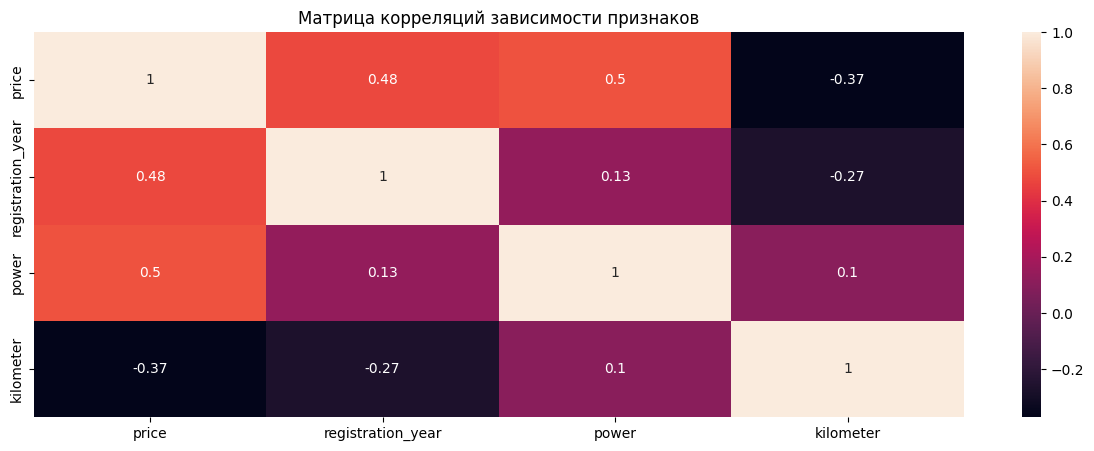

In [102]:
# Проверим корреляцию Пирсона:
plt.figure(figsize=(15, 5))
plt.title('Матрица корреляций зависимости признаков')

sns.heatmap(df.corr(), annot = True)

plt.show()

interval columns not set, guessing: ['price', 'registration_year', 'power', 'kilometer']


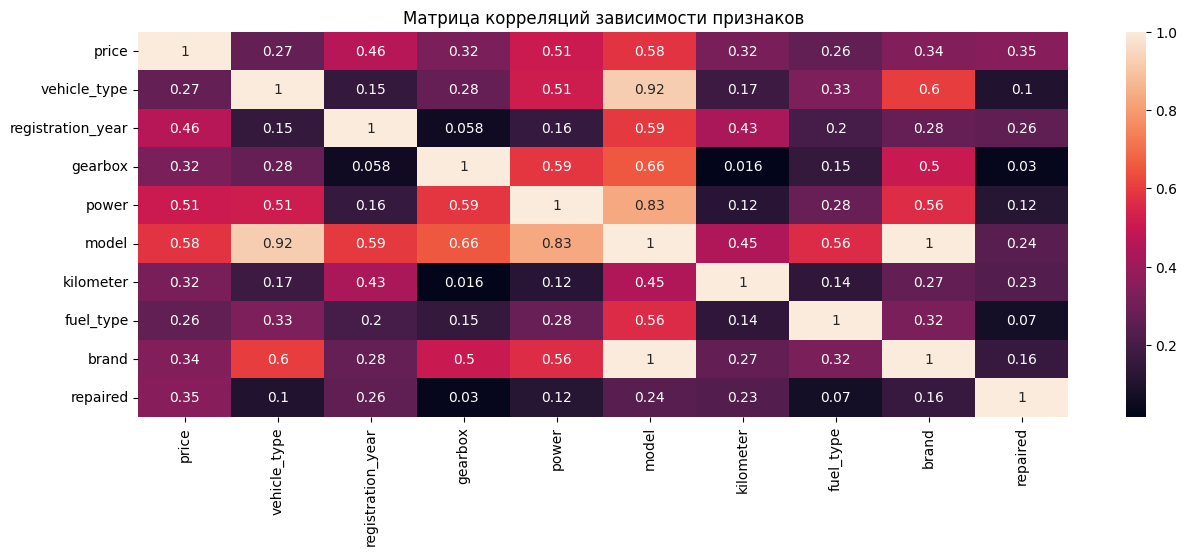

In [103]:
# Проверим Phi_K корреляцию параметров:
plt.figure(figsize=(15, 5))
plt.title('Матрица корреляций зависимости признаков')

sns.heatmap(df.phik_matrix(), annot = True)

plt.show()

### Изменение типа данных

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312860 entries, 0 to 312859
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              312860 non-null  int64  
 1   vehicle_type       312860 non-null  object 
 2   registration_year  312860 non-null  int64  
 3   gearbox            312860 non-null  object 
 4   power              312860 non-null  float64
 5   model              312860 non-null  object 
 6   kilometer          312860 non-null  int64  
 7   fuel_type          312860 non-null  object 
 8   brand              312860 non-null  object 
 9   repaired           312860 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 23.9+ MB


In [105]:
df['gearbox'].unique()

array(['manual', 'auto'], dtype=object)

In [106]:
df['repaired'].unique()

array(['unknown', 'no', 'yes'], dtype=object)

In [107]:
# Проведем замену столбцов gearbox и repaired на булев тип:
# is_manual_gearbox: 1(manual) - означает механическую коробку передач, 0(auto) - автоматическую.
df['is_manual_gearbox'] = 0
df.loc[df['gearbox'] == 'manual', 'is_manual_gearbox'] = 1
display(df['is_manual_gearbox'].value_counts())
df['gearbox'].value_counts()

1    251774
0     61086
Name: is_manual_gearbox, dtype: int64

manual    251774
auto       61086
Name: gearbox, dtype: int64

In [108]:
# is_repaired: 1(yes) - означает машину с ремонтом, 0(no) - без ремонта, 2(unknown) - неизвестно.
df['is_repaired'] = 2
df.loc[df['repaired'] == 'yes', 'is_repaired'] = 1
df.loc[df['repaired'] == 'no', 'is_repaired'] = 0
display(df['is_repaired'].value_counts())
df['repaired'].value_counts()

0    229048
2     52928
1     30884
Name: is_repaired, dtype: int64

no         229048
unknown     52928
yes         30884
Name: repaired, dtype: int64

In [109]:
# Удалим ненужные столбцы и уменьшим размерность хранения типа для ускорения работы с дата фреймом:
df.drop(['repaired','gearbox'], inplace=True, axis=1)
df['is_repaired'] = pd.to_numeric(df['is_repaired'], downcast='integer')
df['is_manual_gearbox'] = pd.to_numeric(df['is_manual_gearbox'], downcast='integer')
df['registration_year'] = pd.to_numeric(df['registration_year'], downcast='integer')
df['power'] = pd.to_numeric(df['power'], downcast='integer')
df['kilometer'] = pd.to_numeric(df['kilometer'], downcast='integer')
df['price'] = pd.to_numeric(df['price'], downcast='integer')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312860 entries, 0 to 312859
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              312860 non-null  int16  
 1   vehicle_type       312860 non-null  object 
 2   registration_year  312860 non-null  int16  
 3   power              312860 non-null  float64
 4   model              312860 non-null  object 
 5   kilometer          312860 non-null  int32  
 6   fuel_type          312860 non-null  object 
 7   brand              312860 non-null  object 
 8   is_manual_gearbox  312860 non-null  int8   
 9   is_repaired        312860 non-null  int8   
dtypes: float64(1), int16(2), int32(1), int8(2), object(4)
memory usage: 14.9+ MB


## Вывод
1. Датафрейм содержит как количественные, так и качественные признаки.
2. Проверили данные на дубликаты и удалили их.
3. Были определены значимые признаки для определения стоимости автомобиля, все остальные признаки были удалены (date_crawled, registration_month, date_created, number_of_pictures, postal_code, last_seen).
4. В данных были обработаны пропуски:
 - Признак model является одним из основных для предсказания цены. Пропущено 6% данных в этом признаке. Нет возможности восстановить корректно эти данные, поэтому удалли пропуски.
 - Доля пропусков в признаке repaired составила 20% - значительна, чтобы просто так удалить. Но и заполнить пропуски на основе имеющихся не получится, поэтому заполнили пропуски значением 'unknown'.
 - Признаки vehicle_type, gearbox, fuel_type c большой вероятностью одинаковы в одинаковых моделях автомобилей. Заполнили пропуски в данных признаках наиболее частым значением той же модели.
5. Значения признака price обладают высоким стандартным отклонениям, что пагубно повлияет на работу алгоритма. Поэтому признак был исследован на аномальные значения.
6. Минимальное значение признака registration_year - 1000, но таких значений крайне мало, 99% больше 1979. Что-то похожее на автомобиль впервые появилось в 1886, и одна из первых машин для широкой публики в 1908 (Ford Model T). Ограничем значения признака: год регистрации не может быть больше 2016, и не может быть меньше 1908. Все показания выше или ниже этих значений удалили.
7. Признак power был исследован подробне на аномальные значения. Важно отметить, что этот признак содержал большое количество объектов со значением 0. Скорее всего, владелец автомобиля, при заполнинии анкеты, посто не указал мощность своего автомобиля, поэтому эти 0 можно воспринимать как пропуски и заменить на медиану, в зависимости от такого признака как model. Также были удалены значения вне диапазона от 25 л.с. до 350 л.с.
8. Признак kilometer имеет достаточно реальные значения, поэтому искать там выбросы не стали. Но для данного признака интересно отметить дискретное распределение признака, и, по сути, его можно отнести к категориальным признакам.
9. Были изменены типы данных: выйгрыш в памяти составляет 9 МВ.


## Обучение моделей

### Преобразование признаков
В колонке Model 249 различных значений, OneHotEncoding добавит к данным 248 столбцов, а порядковое кодирование может неверно трактоваться некоторыми моделями, поэтому попробуем совместить его с признаком Brand и закодировать значением: Model.size() / Brand.size()

In [110]:
df['brand_model'] = df['brand'].astype(str) + ' ' + df['model'].astype(str)
df['model_code'] = df['brand_model'].map(df.groupby('brand_model').size()) / \
                     df['brand'].map(df.groupby('brand').size())
df_coded = df.drop(['brand_model', 'brand', 'model'], axis=1)

In [111]:
df_coded.head()

,price,vehicle_type,registration_year,power,kilometer,fuel_type,is_manual_gearbox,is_repaired,model_code
0,480,sedan,1993,101.0,150000,petrol,1,2,0.392771
1,9800,suv,2004,163.0,125000,gasoline,0,2,0.370915
2,1500,small,2001,75.0,150000,petrol,1,0,0.392771
3,3600,small,2008,69.0,90000,gasoline,1,0,0.387850
4,650,sedan,1995,102.0,150000,petrol,1,1,0.563278


### Разбиение данных на выборки

In [112]:
# Выделим признаки и целевой признак
X = df_coded.drop('price', axis=1)
y = df_coded['price']

In [113]:
# Разделим выборку на обучающую и тестовую
random = 12345
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=0.80,
                                                    test_size=0.20,
                                                    random_state=random)

In [114]:
# Проверим размеры выборок
samples = {'Размер обучающей выборки' : X_train,
          'Размер тестовой выборки': X_test}

for key, value in samples.items():
    print(key + ':', value.shape)

Размер обучающей выборки: (250288, 8)
Размер тестовой выборки: (62572, 8)


### Кодирование признаков

In [115]:
df_coded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312860 entries, 0 to 312859
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              312860 non-null  int16  
 1   vehicle_type       312860 non-null  object 
 2   registration_year  312860 non-null  int16  
 3   power              312860 non-null  float64
 4   kilometer          312860 non-null  int32  
 5   fuel_type          312860 non-null  object 
 6   is_manual_gearbox  312860 non-null  int8   
 7   is_repaired        312860 non-null  int8   
 8   model_code         312860 non-null  float64
dtypes: float64(2), int16(2), int32(1), int8(2), object(2)
memory usage: 12.5+ MB


In [116]:
# Для кодирования использую OrdinalEncoder
c = (X_train.dtypes == 'object')
object_cols = list(c[c].index)

encoder = OrdinalEncoder()

X_train[object_cols] = encoder.fit_transform(X_train[object_cols])
X_test[object_cols] = encoder.transform(X_test[object_cols])

In [117]:
X_train.sample(5)

,vehicle_type,registration_year,power,kilometer,fuel_type,is_manual_gearbox,is_repaired,model_code
71895,7.0,2004,101.0,100000,6.0,1,0,0.243506
235403,7.0,2009,109.0,80000,2.0,1,0,0.215229
62155,0.0,2013,140.0,40000,2.0,0,0,0.047445
297864,7.0,2004,109.0,150000,2.0,1,2,0.243506
780,4.0,1996,150.0,150000,6.0,1,0,0.273015


### Масштабирование признаков

In [118]:
# Проведём масштабирование признаков к стандартному нормальному распределению
# с помощью метода StandardScaler библиотеки sklearn
numeric = ['registration_year', 'power', 'kilometer']

scaler = StandardScaler()
scaler.fit(X_train[numeric])

X_train[numeric] = scaler.transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

In [119]:
X_train.sample(5)

,vehicle_type,registration_year,power,kilometer,fuel_type,is_manual_gearbox,is_repaired,model_code
112275,0.0,-0.418713,-0.335009,0.582389,2.0,1,0,0.004845
297714,4.0,0.339656,0.119304,0.582389,6.0,1,0,0.304094
189838,4.0,0.794678,-0.275750,0.582389,2.0,1,2,0.392771
24690,4.0,0.036308,-0.236245,0.582389,2.0,1,0,0.215229
50197,4.0,0.187982,0.613123,0.582389,6.0,1,1,0.214041


### Обучение моделей

In [120]:
analisys = pd.DataFrame({'model':[], 'RMSE':[], 'time_to_learn':[], 'time_to_predict':[]})

all_models = []

kfold = KFold(n_splits = 3, random_state=random, shuffle=True)

def train_model(model, parameters):
    """

    input:        model - инициализированная модель
                  parameters - словарь с заданными рандомными параметрами

    output:       time_to_learn - время обучения модели
                  model_random - параметры модели, подобранные с помощью RandomizedSearchSV
                  rmse - cреднеквадратичная ошибка

    description:  функция обучит модель, замерит время обучения и вернет подобранные гиперпараметры,
                  рассчитает и вернет метрику RMSE,
                  соберет все полученные метрики в список.


    """

    model_random = RandomizedSearchCV(estimator=model,
                                      # Используем индивидуальные параметры для каждой модели
                                      param_distributions=parameters,
                                      n_iter=100,
                                      scoring='neg_mean_absolute_error',
                                      cv=kfold,
                                      verbose=1,
                                      random_state=random)

    # Посмотрим время обучения
    start = time()
    model_random.fit(X_train, y_train)
    time_to_learn = time() - start
    print('RandomizedSearchCV подбирал параметры %.2f секунд' %time_to_learn)

    start = time()
    model_random.predict(X_train)
    time_to_predict = time() - start
    print('Модель предсказывает за %.2f секунд' %time_to_predict)

    # Высчитаем метрику
    rmse = model_random.best_score_ * -1 ** 0.5

    print('Лучшие параметры:', model_random.best_params_)
    print('RMSE обученной модели:', rmse)

    # Заполним все таблицы
    all_models.append(model_random)
    row = []
    row.extend([model, rmse, time_to_learn, time_to_predict])
    analisys.loc[len(analisys.index)] = row

    return model_random, rmse

#### DecisionTreeRegressor

In [121]:
# Зададим рандомные параметры
ran_grid_tree = {"max_depth": list(range(10, 25))}

# Инициализируем модель
dtr_model = DecisionTreeRegressor(random_state=random)

# Обучим и сохраним значения
dtr_random, rmse_dtr = train_model(dtr_model, ran_grid_tree)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
RandomizedSearchCV подбирал параметры 29.83 секунд
Модель предсказывает за 0.09 секунд
Лучшие параметры: {'max_depth': 19}
RMSE обученной модели: 1154.8664087388263


#### RandomForestRegressor

In [122]:
# Зададим рандомные параметры
ran_grid_forest = {'max_depth': [2, 3, 4],
                   'n_estimators': [100, 200, 300]
                  }

# Инициализируем модель
rfr_model = RandomForestRegressor(n_jobs=-1, random_state=random)

# Обучим и сохраним значения
rfr_random, rmse_rfr = train_model(rfr_model, ran_grid_forest)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
RandomizedSearchCV подбирал параметры 479.23 секунд
Модель предсказывает за 2.12 секунд
Лучшие параметры: {'n_estimators': 300, 'max_depth': 4}
RMSE обученной модели: 1747.9174812860729


#### LGBMRegressor

In [123]:
# Зададим рандомные параметры
rand_lgbm_param = {'max_depth': [5, 10, 15, 25, 35],
                   'learning_rate': [0.1, 0.3, 0.5, 0.7]
                  }

# Инициализируем модель
lgbm_model = lgb.LGBMRegressor(boosting_type='gbdt',
                               objective = 'regression',
                               metric = 'RMSE',
                               random_state=random)

# Обучим и сохраним значения
gbm_random, rmse_gbm = train_model(lgbm_model, rand_lgbm_param)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
RandomizedSearchCV подбирал параметры 100.62 секунд
Модель предсказывает за 0.86 секунд
Лучшие параметры: {'max_depth': 10, 'learning_rate': 0.5}
RMSE обученной модели: 1038.153453097794


#### XGBoost

In [124]:
# Зададим рандомные параметры
rand_xgb_param = {'max_depth': [12, 13, 14, 15],
                  'learning_rate': [0.1, 0.15, 0.3]
                 }

# Инициализируем модель
xgb_model = xgb.XGBRegressor(booster='gbtree',
                      eval_metric='rmse',
                      use_rmm=True)

# Обучим и сохраним значения
xb_random, rmse_xb = train_model(xgb_model, rand_xgb_param)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
RandomizedSearchCV подбирал параметры 1490.47 секунд
Модель предсказывает за 1.68 секунд
Лучшие параметры: {'max_depth': 12, 'learning_rate': 0.15}
RMSE обученной модели: 963.604736328125


#### CatBoostRegressor

In [125]:
# Зададим рандомные параметры
rand_cat_param = {'max_depth': [8, 9, 10, 11],
                  'learning_rate': [0.01, 0.1, 0.2]
                 }

# Инициализируем модель
cbr_model = CatBoostRegressor(loss_function='RMSE')

cat_random, rmse_cat = train_model(cbr_model, rand_cat_param)

Выходные данные были обрезаны до нескольких последних строк (5000).
4:	learn: 2555.3152879	total: 245ms	remaining: 48.7s
5:	learn: 2406.3407048	total: 303ms	remaining: 50.1s
6:	learn: 2291.4153814	total: 348ms	remaining: 49.4s
7:	learn: 2209.9034587	total: 395ms	remaining: 48.9s
8:	learn: 2142.5641317	total: 449ms	remaining: 49.4s
9:	learn: 2094.8082078	total: 502ms	remaining: 49.7s
10:	learn: 2059.3451953	total: 564ms	remaining: 50.7s
11:	learn: 2031.6353564	total: 620ms	remaining: 51s
12:	learn: 1999.6691543	total: 672ms	remaining: 51s
13:	learn: 1981.3488941	total: 719ms	remaining: 50.7s
14:	learn: 1959.5455640	total: 789ms	remaining: 51.8s
15:	learn: 1947.0512752	total: 837ms	remaining: 51.5s
16:	learn: 1934.2689222	total: 884ms	remaining: 51.1s
17:	learn: 1922.8436334	total: 930ms	remaining: 50.8s
18:	learn: 1906.0627845	total: 977ms	remaining: 50.4s
19:	learn: 1897.6336015	total: 1.04s	remaining: 50.9s
20:	learn: 1888.6545281	total: 1.09s	remaining: 50.6s
21:	learn: 1875.8338906	

## Анализ моделей

In [126]:
all_names = pd.DataFrame({'names':['DecisionTree', 'RandomForest', 'LightGBM', 'XGBoost', 'CatBoost']})
analisys = pd.concat([analisys, all_names], axis=1, join='inner')
display(analisys)

,model,RMSE,time_to_learn,time_to_predict,names
0,DecisionTreeRegressor(random_state=12345),1154.866409,29.829853,0.091233,DecisionTree
1,"RandomForestRegressor(n_jobs=-1, random_state=...",1747.917481,479.230756,2.123824,RandomForest
2,"LGBMRegressor(metric='RMSE', objective='regres...",1038.153453,100.624699,0.864296,LightGBM
3,"XGBRegressor(base_score=None, booster='gbtree'...",963.604736,1490.467043,1.678788,XGBoost
4,<catboost.core.CatBoostRegressor object at 0x7...,960.454342,2094.977256,1.183840,CatBoost


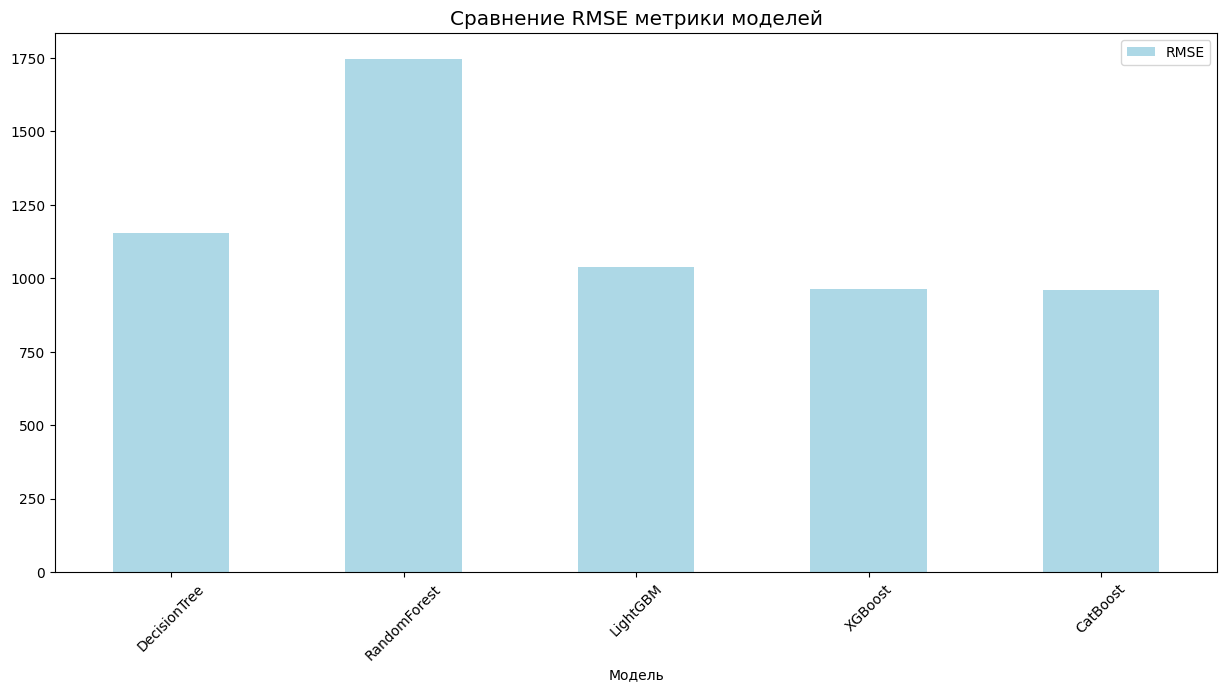

In [127]:
analisys.plot.bar(y='RMSE', x='names', rot=45, figsize=(15,7), color='lightblue')
plt.title('Сравнение RMSE метрики моделей', fontsize='x-large')
plt.xlabel('Модель')
plt.show();

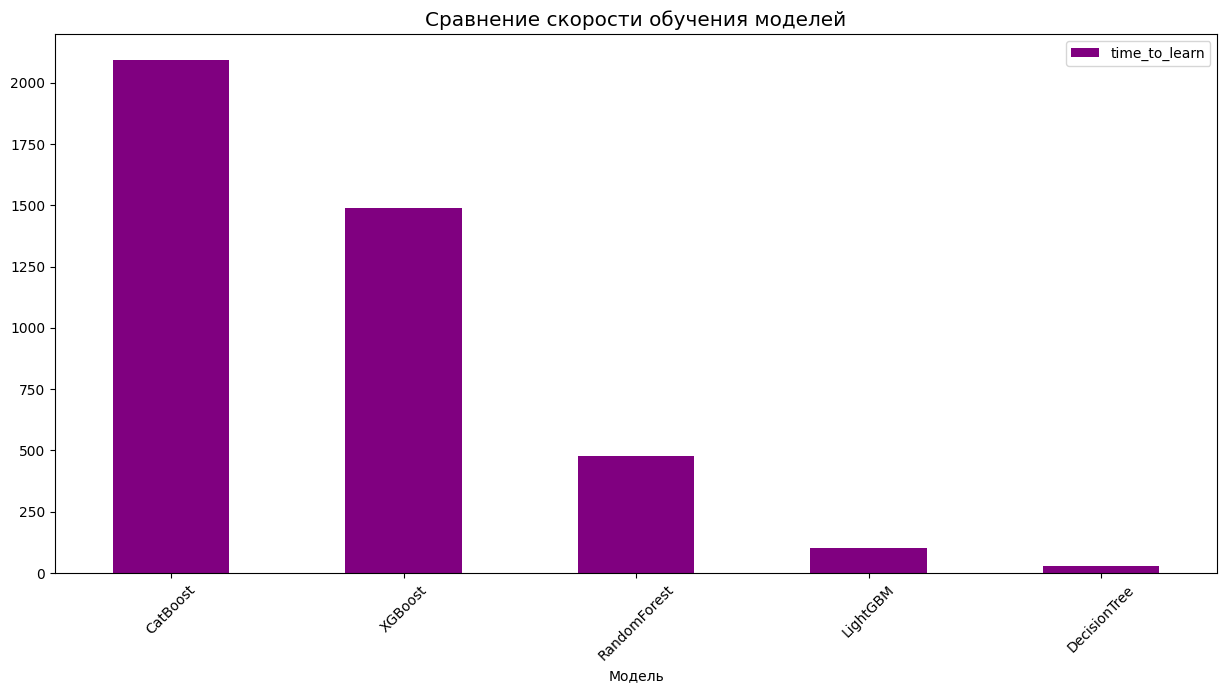

In [128]:
analisys.sort_values(by='time_to_learn', ascending=False)\
.plot.bar(y='time_to_learn', x='names', rot=45, figsize=(15,7), color='purple')
plt.title('Сравнение скорости обучения моделей', fontsize='x-large')
plt.xlabel('Модель')
plt.show();

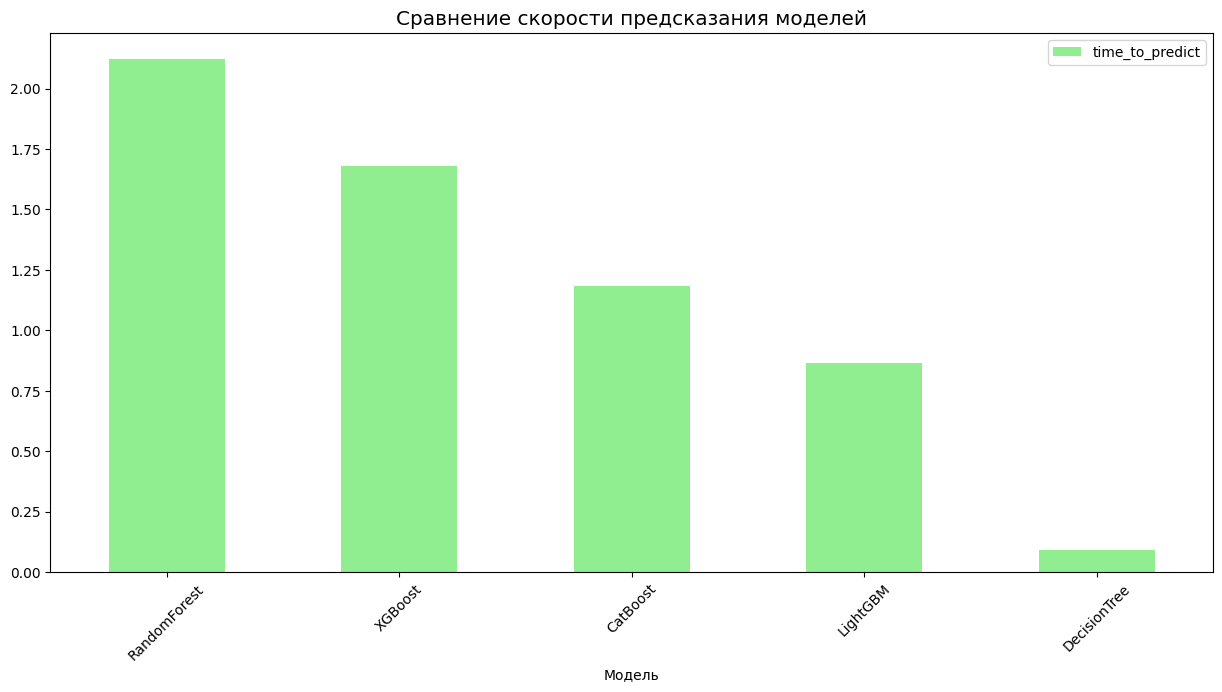

In [129]:
analisys.sort_values(by='time_to_predict', ascending=False)\
.plot.bar(y='time_to_predict', x='names', rot=45, figsize=(15,7), color='lightgreen')
plt.title('Сравнение скорости предсказания моделей', fontsize='x-large')
plt.xlabel('Модель')
plt.show();

> **По всем трём параметрам, важным для заказчика - качество предсказания, скорость предсказания и время обучения - лучший результат показывает модель DecisionTreeRegressor. Сочетания скорости и точности на подготовленных данных выводит его в лидеры рейтинга: время обучения - 28.46 секунд, время предсказания - 0.09 секунд, RMSE - 1154. Все остальные показали себя в целом хуже.**
>
> Если оценивать только точность предсказания, то в лидеры выходит CatBoostRegressor. Следом за ним идет XGBRegressor и LGBMRegressor занимает третье место.
>
> **Самые оптимальные показатели времени предсказания/качества модели - CatBoost. Стоит выделить именно обученную модель CatBoost и использовать ее.**

In [131]:
start = time()
predicted = cat_random.predict(X_test)
print('Модель предсказывает не тестовой выборке за %.2f секунд' %(time() - start))

rmse_on_test = mean_squared_error(y_test, predicted, squared=False)
print('Итоговый RMSE на тестовой выборке:', rmse_on_test)

Модель предсказывает не тестовой выборке за 0.32 секунд
Итоговый RMSE на тестовой выборке: 1523.2796300371203


In [132]:
# Сравним работу модели с работой случайной модели
dummy_regr = DummyRegressor(strategy='mean')

dummy_regr.fit(X_train, y_train)
predicted = dummy_regr.predict(X_test)
rmse_on_dummy = mean_squared_error(y_test, predicted, squared=False)
print('Итоговый RMSE случайной модели:', rmse_on_dummy)

Итоговый RMSE случайной модели: 4535.14698790931


# Вывод:
**В ходе работы было выполнено:**
1. Загружены данные и проведена предобработка.
2. Выполнено сравнение моделей с использованием различных наборов гиперпараметров.
3. Выбрана лучшая модель по результатам метрики RMSE и времени предсказания.
4. На выбор модели не влияло время обучения на кросвалидации, так как на одном типе данных ее проводят один раз. В то время как переобучать модель на новых данных приходится намного чаще.
Исходя из полученного рейтинга можно выделить специфику задач для регрессоров.
5. Лучшей моделью по трем параметрам качество, скорость обучения и скорость предсказания можно считать CatBoostRegressor. Сочетания скорости и точности на подготовленных данных выводит его в лидеры рейтинга. Все остальные показали себя в целом хуже.
